In [1]:
import lale.operators
from lale.lib.sklearn import GaussianNB
class NonIncWrapper:
    def __init__(self, *, op=None):
        self._op = op
    def getOp(self):
        return self._op
    def fit(self, X, y):
        self._op.fit(X, y)
        return self._op
    def predict(self, X):
        return self._op.predict(X)
NonIncWrapper = lale.operators.make_operator(NonIncWrapper).customize_schema(forwards=False)
NonIncGauss = NonIncWrapper(op=GaussianNB())
try:
    trained = NonIncGauss.partial_fit(None, None, classes=None)
    assert False, "should not have a partial fit method"
except AttributeError as e:
    assert str(e) == "NonIncWrapper has no partial_fit implemented."

In [2]:
import pandas as pd
import statistics
import time
import IPython.display
import matplotlib.pyplot as plt
from lale.lib.rasl import cross_val_score
from lale.lib.rasl import fit_with_batches
from lale.lib.rasl import get_scorer
from lale.lib.rasl import mockup_data_loader
from lale.lib.rasl import PrioBatch
from sklearn.model_selection import StratifiedKFold

TEST_SIZE = 0.333

scoring = get_scorer("balanced_accuracy")
prio = PrioBatch()

def evaluate_one(data, regime, n_splits, config_name, trainable):
    train_X, train_y = data["train_X"], data["train_y"]
    holdout_X, holdout_y = data["holdout_X"], data["holdout_y"]
    start_time = time.time()
    if regime == "holdout":
        trained = fit_with_batches(
            pipeline=trainable,
            batches_train=mockup_data_loader(train_X, train_y, n_splits, "pandas"),
            batches_valid=None,
            scoring=None,
            unique_class_labels=list(train_y.unique()),
            max_resident=None,
            prio=prio,
            partial_transform=False,
            verbose=0,
            progress_callback=None,
        )
        scores = [scoring(trained, holdout_X, holdout_y)]
    else:
        scores = cross_val_score(
            pipeline=trainable,
            batches=[(train_X, train_y)],
            scoring=scoring,
            cv=StratifiedKFold(n_splits),
            unique_class_labels=list(train_y.unique()),
            max_resident=None,
            prio=prio,
            same_fold=True if regime == "inf_cv" else False,
            verbose=0,
        )
    end_time = time.time()
    result = {
        "data": data["name"],
        "regime": regime,
        "n_splits": n_splits,
        "config_name": config_name,
        "score_avg": statistics.mean(scores),
        "score_std": 0 if len(scores) == 1 else statistics.stdev(scores),
        "time": end_time - start_time,
    }
    return result

def evaluate(data, n_splits_list, trainables):
    records = [
        evaluate_one(data, regime, n_splits, config_name, trainable.clone())
        for config_name, trainable in trainables
        for regime in ["holdout", "inf_cv", "oof_cv"]
        for n_splits in n_splits_list
    ]
    return pd.DataFrame.from_records(records)


pd.set_option("display.precision", 4)

In [3]:
def logrange(lo, hi, n):
    assert lo < hi and n > 0 and int(n) == n
    base = (hi / lo) ** (1 / (n - 1.0))
    return [lo * (base ** i) for i in range(n)]

logrange(1e-6, 1e-1, 6)

[1e-06,
 1e-05,
 0.00010000000000000003,
 0.0010000000000000005,
 0.010000000000000007,
 0.10000000000000009]

In [4]:
from sklearn.inspection import permutation_importance
from lale.lib.xgboost import XGBClassifier
import config

def load_data(dataset_name, test_size, distribution_shift):
    (train_X, train_y), (test_X, test_y) = config.get_data(
        dataset_name, astype="pandas",
    )
    X = pd.concat([train_X, test_X], axis=0)
    y = pd.concat([train_y, test_y], axis=0)
    trainable = config.get_prefix_rasl(dataset_name, False) >> XGBClassifier()
    trained = trainable.fit(X, y)
    feature_importances = permutation_importance(
        trained, X, y, scoring=scoring
    )["importances_mean"]
    top_feature = X.columns[feature_importances.argmax()]
    if distribution_shift:
        y_and_X = pd.concat([y, X], axis=1).sort_values(top_feature)
    else:
        y_and_X = pd.concat([y, X], axis=1)
    n_rows_train = int(len(y_and_X) * (1 - test_size))
    return {
        "name": dataset_name,
        "top_feature": top_feature,
        "train_X": y_and_X.iloc[:n_rows_train, 1:],
        "train_y": y_and_X.iloc[:n_rows_train, 0],
        "holdout_X": y_and_X.iloc[n_rows_train:, 1:],
        "holdout_y": y_and_X.iloc[n_rows_train:, 0],
    }

In [5]:
from lale.lib.sklearn import GaussianNB
from lale.lib.sklearn import MultinomialNB
from lale.lib.sklearn import Perceptron
from lale.lib.sklearn import SGDClassifier
from lale.lib.sklearn import PassiveAggressiveClassifier
from lale.lib.sklearn import MLPClassifier
from lale.lib.rasl import BatchedBaggingClassifier
from lale.lib.snapml import BatchedTreeEnsembleClassifier
from lale.lib.lightgbm import LGBMClassifier
from lale.lib.xgboost import XGBClassifier

# suppress MLPClassifier warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [6]:
def create_pipeline(dataset_name, est):
    if est.impl.getOp().name() == "MultinomialNB":
        prefix = config.get_prefix_rasl(dataset_name, True)
    else:
        prefix = config.get_prefix_rasl(dataset_name, False)
    return prefix >> est

def evaluate_estimators(data):
    estimators = [
        NonIncWrapper(op=GaussianNB()),
        NonIncWrapper(op=MultinomialNB()),
        NonIncWrapper(op=Perceptron()),
        NonIncWrapper(op=SGDClassifier(random_state=42)),
        NonIncWrapper(op=PassiveAggressiveClassifier(random_state=42)),
        NonIncWrapper(op=MLPClassifier(random_state=42)),
        NonIncWrapper(op=BatchedBaggingClassifier()),
        NonIncWrapper(op=BatchedTreeEnsembleClassifier()),
        NonIncWrapper(op=LGBMClassifier()),
        NonIncWrapper(op=XGBClassifier())
    ]
    n_splits_list = [3, 4, 5]
    df = evaluate(
        data,
        n_splits_list,
        [(x.impl.getOp().name(), create_pipeline(data["name"], x)) for x in estimators]
    )
    def move_to_columns(regime, n_splits):
        df_selected = df[(df["regime"] == regime) & (df["n_splits"] == n_splits)]
        df_indexed = df_selected.set_index(["data", "config_name"], drop=True)
        column_name_prefix = regime if n_splits==1 else f"{regime}{n_splits}"
        df_projected = pd.DataFrame({
            f"{column_name_prefix}_score": df_indexed["score_avg"],
            f"{column_name_prefix}_time": df_indexed["time"],
        })
        return df_projected
    df_cvs = [move_to_columns(r, k) for r in df["regime"].unique() for k in n_splits_list]
    df_all = pd.concat(df_cvs, axis=1)
    result = df_all.reset_index()
    return result

In [7]:
datasets = [  # elide shuttle and kddcup99full because the kernel died
    "spectf",
    "breast-cancer",
    "Australian",
    "blood-transfusion-service-center",
    "diabetes",
    "credit-g",
    "car",
    "mfeat-factors",
    "kc1",
    "kr-vs-kp",
    "sylvine",
    "phoneme",
    "jungle_chess_2pcs_raw_endgame_complete",
]
all_est_dfs = []
for dataset_name in datasets:
    data = load_data(dataset_name, TEST_SIZE, False)
    print(f"dataset '{data['name']}', top_feature '{data['top_feature']}'")
    est_results = evaluate_estimators(data)
    IPython.display.display(est_results)
    all_est_dfs.append(est_results)
all_est_df = pd.concat(all_est_dfs, ignore_index=True)

dataset 'spectf', top_feature 'f20s'


,data,config_name,holdout3_score,holdout3_time,holdout4_score,holdout4_time,holdout5_score,holdout5_time,inf_cv3_score,inf_cv3_time,inf_cv4_score,inf_cv4_time,inf_cv5_score,inf_cv5_time,oof_cv3_score,oof_cv3_time,oof_cv4_score,oof_cv4_time,oof_cv5_score,oof_cv5_time
0,spectf,GaussianNB,0.7493,0.6406,0.7493,0.9102,0.7493,1.1444,0.7778,1.2558,0.8004,1.9467,0.8387,5.2771,0.7797,1.4778,0.7967,1.8862,0.7731,2.0468
1,spectf,MultinomialNB,0.5000,1.8071,0.5000,1.5641,0.5000,1.5429,0.5000,1.9238,0.5000,3.5346,0.5000,4.8118,0.5000,1.1704,0.5000,1.1142,0.5000,1.6502
2,spectf,Perceptron,0.4941,0.6503,0.4941,0.8244,0.6285,1.1047,0.7060,1.3762,0.6015,2.1638,0.6919,2.9471,0.6423,0.6988,0.5639,1.1670,0.5371,1.1253
3,spectf,SGDClassifier,0.7259,0.5380,0.7259,0.8317,0.7259,1.1139,0.7093,1.2685,0.6880,2.3281,0.6429,2.9966,0.6378,0.7475,0.5132,0.9703,0.7021,1.1903
4,spectf,PassiveAggressiveClassifier,0.5818,0.7261,0.5818,1.1849,0.5818,1.8551,0.7975,1.9794,0.7675,3.3512,0.7887,5.8377,0.7644,0.8521,0.7417,1.1593,0.7351,1.7250
5,spectf,MLPClassifier,0.5136,6.2381,0.5136,4.7607,0.5136,5.6869,0.7197,16.5186,0.7096,14.4306,0.7401,24.6505,0.7201,13.4682,0.6797,21.6263,0.7486,14.0331
6,spectf,BatchedBaggingClassifier,0.7849,0.8702,0.6989,0.8892,0.8494,1.0224,0.7225,1.2676,0.7921,2.2340,0.7819,3.4057,0.6948,0.5629,0.7283,0.8957,0.7028,1.1213
7,spectf,BatchedTreeEnsembleClassifier,0.8064,0.8066,0.8064,1.1800,0.8064,1.0799,0.8099,2.1340,0.8363,4.1168,0.8317,6.4376,0.7333,0.9535,0.7768,1.0894,0.7837,1.4962
8,spectf,LGBMClassifier,0.8006,0.8460,0.8006,0.9495,0.8006,1.2007,0.8041,1.2479,0.8259,2.5279,0.8521,3.3228,0.7572,0.8502,0.8378,1.3480,0.7864,1.7867
9,spectf,XGBClassifier,0.8123,1.0461,0.8123,1.3398,0.8123,1.4077,0.8049,2.1597,0.8087,4.2107,0.8520,4.9806,0.7025,1.7420,0.7748,2.5433,0.7667,3.6874


dataset 'breast-cancer', top_feature 'tumor-size'


,data,config_name,holdout3_score,holdout3_time,holdout4_score,holdout4_time,holdout5_score,holdout5_time,inf_cv3_score,inf_cv3_time,inf_cv4_score,inf_cv4_time,inf_cv5_score,inf_cv5_time,oof_cv3_score,oof_cv3_time,oof_cv4_score,oof_cv4_time,oof_cv5_score,oof_cv5_time
0,breast-cancer,GaussianNB,0.6261,0.8734,0.6261,0.7250,0.6261,0.5953,0.6367,0.8134,0.6625,1.4614,0.6493,2.6873,0.6367,0.4361,0.6625,0.4851,0.6493,0.6361
1,breast-cancer,MultinomialNB,0.5945,0.4485,0.5945,0.5156,0.5945,0.5909,0.6505,0.8454,0.6249,1.5353,0.6508,2.3356,0.6505,0.4255,0.6249,0.4712,0.6508,0.6441
2,breast-cancer,Perceptron,0.5777,0.4194,0.5536,0.5655,0.5462,0.6247,0.4974,0.9913,0.5883,1.5856,0.5567,2.1452,0.5239,0.4257,0.6202,0.5139,0.5654,0.6648
3,breast-cancer,SGDClassifier,0.5945,0.3496,0.5945,0.3666,0.5945,0.7197,0.5265,0.7995,0.5865,1.4342,0.5757,2.0428,0.5265,0.2567,0.5865,0.4936,0.5757,0.4390
4,breast-cancer,PassiveAggressiveClassifier,0.5368,0.4179,0.5368,0.3993,0.5368,0.5490,0.5622,0.6373,0.5590,1.4910,0.5154,2.0333,0.5622,0.3608,0.5590,0.4778,0.5154,0.6463
5,breast-cancer,MLPClassifier,0.5945,2.0758,0.5945,1.9883,0.5945,1.6652,0.6443,8.4065,0.6136,10.0026,0.6296,9.8526,0.6443,3.8721,0.6136,13.8102,0.6296,8.9272
6,breast-cancer,BatchedBaggingClassifier,0.5935,0.3286,0.6155,0.4418,0.5357,0.4729,0.6317,0.7755,0.6056,1.3347,0.6340,2.0678,0.6381,0.3682,0.6091,0.4380,0.5689,0.4554
7,breast-cancer,BatchedTreeEnsembleClassifier,0.6586,0.2893,0.6586,0.4757,0.6586,0.4922,0.6443,0.7606,0.6433,1.1134,0.6255,1.6713,0.6443,0.2958,0.6433,0.3683,0.6255,0.5704
8,breast-cancer,LGBMClassifier,0.6082,0.3050,0.6082,0.3404,0.6082,0.5359,0.5966,0.8889,0.6154,1.3935,0.6508,1.9648,0.5966,0.6319,0.6154,0.4380,0.6508,0.6668
9,breast-cancer,XGBClassifier,0.6439,0.5030,0.6439,0.6740,0.6439,0.6796,0.6116,1.5812,0.6069,2.3674,0.6411,3.1220,0.6116,0.9996,0.6069,1.2195,0.6411,1.9130


dataset 'Australian', top_feature 'a10'


,data,config_name,holdout3_score,holdout3_time,holdout4_score,holdout4_time,holdout5_score,holdout5_time,inf_cv3_score,inf_cv3_time,inf_cv4_score,inf_cv4_time,inf_cv5_score,inf_cv5_time,oof_cv3_score,oof_cv3_time,oof_cv4_score,oof_cv4_time,oof_cv5_score,oof_cv5_time
0,Australian,GaussianNB,0.7731,0.6369,0.7731,0.6719,0.7731,0.8075,0.7488,1.0538,0.7469,1.9433,0.7558,4.0323,0.7443,0.7579,0.7443,1.0918,0.7533,0.8951
1,Australian,MultinomialNB,0.7804,0.5443,0.7804,1.1147,0.7804,1.5265,0.7613,1.4760,0.7582,2.7842,0.7588,5.6295,0.7613,0.5333,0.7563,0.8114,0.7588,0.9607
2,Australian,Perceptron,0.5000,0.6907,0.7335,0.7221,0.7469,0.8708,0.7433,1.6009,0.7106,2.8204,0.6709,5.4661,0.6476,0.9037,0.7100,1.6169,0.7179,1.2778
3,Australian,SGDClassifier,0.7504,1.2639,0.7504,1.8283,0.7504,1.8517,0.7168,2.2548,0.6823,4.9519,0.7591,7.8484,0.5996,1.5539,0.6833,1.7661,0.7506,1.7754
4,Australian,PassiveAggressiveClassifier,0.8235,1.0946,0.8235,1.1856,0.8235,1.2579,0.6258,1.8596,0.6992,2.9426,0.6313,3.5157,0.6283,0.6780,0.6992,0.9888,0.6338,1.1903
5,Australian,MLPClassifier,0.8077,7.6107,0.8077,8.8377,0.8077,10.3534,0.7509,21.4559,0.7364,34.2336,0.7635,44.4279,0.7535,21.1934,0.7345,22.5597,0.7616,37.4943
6,Australian,BatchedBaggingClassifier,0.6950,1.0081,0.7030,1.2083,0.7519,1.3539,0.7209,2.1930,0.6875,4.5150,0.6549,5.0524,0.6724,0.7491,0.6742,1.0110,0.6782,1.5763
7,Australian,BatchedTreeEnsembleClassifier,0.8119,0.9837,0.8119,1.0290,0.8119,1.4594,0.7482,2.1751,0.7648,3.2307,0.7705,5.7590,0.7343,0.9740,0.7653,1.1206,0.7603,1.3050
8,Australian,LGBMClassifier,0.7996,0.8352,0.7996,1.1838,0.7996,1.4858,0.7571,1.9487,0.7572,2.8034,0.7594,4.4250,0.7616,0.8080,0.7444,1.0774,0.7683,1.3004
9,Australian,XGBClassifier,0.7865,0.9684,0.7865,1.4727,0.7865,1.6512,0.7732,2.6042,0.7495,3.8503,0.7573,5.3252,0.7660,1.5570,0.7634,2.2010,0.7669,2.8333


dataset 'blood-transfusion-service-center', top_feature 'v2'


,data,config_name,holdout3_score,holdout3_time,holdout4_score,holdout4_time,holdout5_score,holdout5_time,inf_cv3_score,inf_cv3_time,inf_cv4_score,inf_cv4_time,inf_cv5_score,inf_cv5_time,oof_cv3_score,oof_cv3_time,oof_cv4_score,oof_cv4_time,oof_cv5_score,oof_cv5_time
0,blood-transfusion-service-center,GaussianNB,0.5484,0.1191,0.5484,0.2512,0.5484,0.1927,0.5540,0.2487,0.5568,0.3573,0.5549,0.5820,0.5543,0.1565,0.5538,0.2079,0.5592,0.4198
1,blood-transfusion-service-center,MultinomialNB,0.5000,0.2200,0.5000,0.1756,0.5000,0.2433,0.5000,0.4085,0.5000,0.5338,0.5000,0.8253,0.5000,0.1864,0.5000,0.4118,0.5000,0.3131
2,blood-transfusion-service-center,Perceptron,0.6508,0.1278,0.5907,0.1412,0.5219,0.2417,0.5963,0.2423,0.5640,0.4203,0.6138,0.7255,0.5815,0.1677,0.6257,0.2027,0.6403,0.3285
3,blood-transfusion-service-center,SGDClassifier,0.5219,0.1440,0.5219,0.1552,0.5219,0.1698,0.6215,0.2072,0.5383,0.4483,0.5745,0.6650,0.5880,0.2340,0.5382,0.2241,0.5436,0.2654
4,blood-transfusion-service-center,PassiveAggressiveClassifier,0.5740,0.1703,0.5740,0.2403,0.5740,0.3249,0.6339,0.3273,0.5613,0.5937,0.5385,0.7797,0.5902,0.3157,0.5613,0.3373,0.5428,0.4578
5,blood-transfusion-service-center,MLPClassifier,0.5798,4.6797,0.5798,5.2142,0.5798,6.7307,0.5437,10.2926,0.5412,17.6211,0.5436,19.5725,0.5296,10.3749,0.5455,18.1577,0.5436,22.7136
6,blood-transfusion-service-center,BatchedBaggingClassifier,0.5745,0.2561,0.5687,0.2243,0.5526,0.2454,0.5892,0.3416,0.6317,0.4645,0.6312,0.7007,0.5965,0.1662,0.5912,0.2399,0.5840,0.3145
7,blood-transfusion-service-center,BatchedTreeEnsembleClassifier,0.6110,0.1442,0.6110,0.1568,0.6110,0.2404,0.6050,0.3518,0.5823,0.5661,0.6041,0.6984,0.5971,0.1835,0.5935,0.2807,0.5877,0.4359
8,blood-transfusion-service-center,LGBMClassifier,0.6282,0.2028,0.6282,0.2936,0.6282,0.2893,0.5816,0.4689,0.5842,0.7815,0.6144,1.0818,0.5974,0.4033,0.5684,0.6328,0.6013,0.6059
9,blood-transfusion-service-center,XGBClassifier,0.6203,0.4465,0.6203,0.4921,0.6203,0.8792,0.5793,1.3783,0.5892,1.8872,0.5955,2.6249,0.5974,1.0921,0.5737,2.5127,0.5815,2.6278


dataset 'diabetes', top_feature 'plas'


,data,config_name,holdout3_score,holdout3_time,holdout4_score,holdout4_time,holdout5_score,holdout5_time,inf_cv3_score,inf_cv3_time,inf_cv4_score,inf_cv4_time,inf_cv5_score,inf_cv5_time,oof_cv3_score,oof_cv3_time,oof_cv4_score,oof_cv4_time,oof_cv5_score,oof_cv5_time
0,diabetes,GaussianNB,0.7688,0.3060,0.7688,0.2533,0.7688,0.2804,0.6867,0.4553,0.6967,0.5326,0.6865,1.3788,0.6828,0.2891,0.7070,0.2735,0.6938,0.4278
1,diabetes,MultinomialNB,0.5000,0.3257,0.5000,0.3210,0.5000,0.5621,0.5000,0.4984,0.5000,1.0716,0.5000,1.3394,0.5000,0.3693,0.5000,0.3365,0.5000,0.5659
2,diabetes,Perceptron,0.7115,0.1961,0.5490,0.3023,0.6948,0.6288,0.6403,0.5155,0.6095,0.7232,0.6464,1.1163,0.6465,0.2621,0.6695,0.4438,0.6100,0.5068
3,diabetes,SGDClassifier,0.7469,0.1952,0.7469,0.4185,0.7469,0.3592,0.7269,0.4354,0.6539,0.7596,0.6271,1.1809,0.7070,0.3884,0.6874,0.3830,0.6692,0.8465
4,diabetes,PassiveAggressiveClassifier,0.6823,0.5015,0.6823,0.6516,0.6823,0.6283,0.5227,0.5475,0.5353,0.8331,0.6186,1.2976,0.5157,0.3274,0.5309,0.6467,0.5893,0.8908
5,diabetes,MLPClassifier,0.7354,8.3731,0.7354,10.0203,0.7354,6.8866,0.6723,15.0815,0.6927,20.6774,0.6499,31.5149,0.6841,14.6064,0.6855,18.7850,0.6413,30.5889
6,diabetes,BatchedBaggingClassifier,0.6042,0.2792,0.6542,0.2646,0.6469,0.2892,0.6543,0.4238,0.6760,0.5763,0.6283,0.9341,0.6657,0.2936,0.6409,0.3224,0.6556,0.3703
7,diabetes,BatchedTreeEnsembleClassifier,0.7177,0.1986,0.7177,0.3112,0.7177,0.2846,0.6780,0.5118,0.6749,0.6975,0.6880,0.8615,0.6971,0.2492,0.7011,0.4369,0.6908,0.4362
8,diabetes,LGBMClassifier,0.6865,0.2814,0.6865,0.3801,0.6865,0.3669,0.6691,0.6103,0.6938,1.0835,0.6880,1.4849,0.6927,0.4857,0.7054,0.6222,0.6938,0.7830
9,diabetes,XGBClassifier,0.6604,0.5951,0.6604,0.7364,0.6604,0.8517,0.6604,1.3878,0.6953,2.2396,0.6969,2.7000,0.6868,1.3485,0.7026,1.9857,0.7038,2.4626


dataset 'credit-g', top_feature 'credit_amount'


,data,config_name,holdout3_score,holdout3_time,holdout4_score,holdout4_time,holdout5_score,holdout5_time,inf_cv3_score,inf_cv3_time,inf_cv4_score,inf_cv4_time,inf_cv5_score,inf_cv5_time,oof_cv3_score,oof_cv3_time,oof_cv4_score,oof_cv4_time,oof_cv5_score,oof_cv5_time
0,credit-g,GaussianNB,0.5675,0.8398,0.5675,1.0860,0.5675,1.4684,0.6116,2.0381,0.6093,3.2727,0.6104,5.1198,0.6001,0.7648,0.6101,1.1181,0.6185,1.1054
1,credit-g,MultinomialNB,0.5053,0.9007,0.5053,1.5013,0.5053,1.2053,0.5111,1.9232,0.5063,3.2224,0.5087,4.9736,0.5101,0.9442,0.5063,1.0086,0.5135,1.3232
2,credit-g,Perceptron,0.6500,0.8550,0.4937,1.1721,0.5000,1.6429,0.5235,2.0145,0.6000,3.5687,0.5851,4.9172,0.5621,0.9122,0.6235,1.0968,0.5743,1.1324
3,credit-g,SGDClassifier,0.5169,0.9384,0.5169,1.1021,0.5169,1.2817,0.5537,1.8896,0.5403,3.7868,0.5706,5.8183,0.5119,1.0863,0.5625,1.8131,0.5900,1.3907
4,credit-g,PassiveAggressiveClassifier,0.5464,1.2813,0.5464,1.5060,0.5464,1.9439,0.5580,3.4340,0.5152,7.6194,0.5770,9.5330,0.5588,1.4309,0.5212,1.5494,0.5887,2.6849
5,credit-g,MLPClassifier,0.5970,20.4378,0.5970,15.9753,0.5970,15.0581,0.6094,38.1068,0.6202,57.9600,0.6280,72.9540,0.5882,39.4740,0.6186,51.8980,0.6202,71.9322
6,credit-g,BatchedBaggingClassifier,0.5676,2.2684,0.5498,2.1763,0.6045,3.0671,0.5689,4.5657,0.5467,6.4307,0.5458,11.2233,0.5668,2.0561,0.5736,1.9181,0.5934,2.4250
7,credit-g,BatchedTreeEnsembleClassifier,0.5980,1.6499,0.5980,2.0218,0.5980,2.8175,0.5936,3.5824,0.5835,6.6674,0.6231,10.4675,0.6041,1.6945,0.5982,2.1467,0.6163,2.8370
8,credit-g,LGBMClassifier,0.5738,1.8511,0.5738,2.3321,0.5738,2.8175,0.6368,4.1922,0.6128,6.9853,0.6464,10.1179,0.6531,1.9920,0.6290,2.4475,0.6578,3.3825
9,credit-g,XGBClassifier,0.6159,2.4423,0.6159,3.2732,0.6159,3.5999,0.6417,5.9408,0.6080,9.3254,0.6375,15.2772,0.6456,3.1707,0.6185,3.9839,0.6431,5.7740


dataset 'car', top_feature 'safety'


,data,config_name,holdout3_score,holdout3_time,holdout4_score,holdout4_time,holdout5_score,holdout5_time,inf_cv3_score,inf_cv3_time,inf_cv4_score,inf_cv4_time,inf_cv5_score,inf_cv5_time,oof_cv3_score,oof_cv3_time,oof_cv4_score,oof_cv4_time,oof_cv5_score,oof_cv5_time
0,car,GaussianNB,0.3057,0.6323,0.3057,0.7850,0.3057,0.8861,0.2864,1.6027,0.2972,3.1441,0.2790,5.1583,0.2864,0.8157,0.2972,1.4704,0.2790,1.3705
1,car,MultinomialNB,0.2500,0.9513,0.2500,1.1440,0.2500,1.6490,0.2500,2.0291,0.2500,3.4411,0.2500,4.7233,0.2500,0.9255,0.2500,1.0391,0.2500,1.2391
2,car,Perceptron,0.2500,0.8887,0.2617,1.0302,0.2500,1.2144,0.2598,1.7129,0.2684,2.6338,0.2554,3.9592,0.3119,1.0251,0.2644,1.0395,0.2787,1.2504
3,car,SGDClassifier,0.3420,0.7485,0.3420,0.9233,0.3420,1.1880,0.2386,1.9278,0.2569,2.8245,0.2782,4.3542,0.2386,0.8209,0.2569,0.9269,0.2782,1.2254
4,car,PassiveAggressiveClassifier,0.3028,1.3030,0.3028,1.6622,0.3028,1.5828,0.2713,2.5793,0.2768,4.7956,0.2460,6.4885,0.2713,1.7047,0.2768,2.8303,0.2460,3.6858
5,car,MLPClassifier,0.2500,4.1008,0.2500,4.1207,0.2500,4.3515,0.2506,8.0943,0.2523,11.5966,0.2486,16.2764,0.2506,7.3749,0.2523,11.9885,0.2486,14.2642
6,car,BatchedBaggingClassifier,0.2576,0.6843,0.2576,0.7552,0.2576,0.8723,0.2650,1.6009,0.2668,2.7138,0.2586,4.2382,0.2650,0.8456,0.2668,0.9013,0.2586,1.4369
7,car,BatchedTreeEnsembleClassifier,0.2500,1.2213,0.2500,1.1457,0.2500,1.1533,0.2643,1.8089,0.2668,3.1747,0.2487,5.2129,0.2643,1.1865,0.2668,1.3751,0.2487,1.5831
8,car,LGBMClassifier,0.2576,1.3698,0.2576,1.2600,0.2576,1.3741,0.2643,2.6936,0.2661,3.8765,0.2579,5.9537,0.2643,1.7429,0.2661,2.3603,0.2579,3.1660
9,car,XGBClassifier,0.2576,2.4672,0.2576,2.3799,0.2576,2.5473,0.2650,5.7660,0.2668,8.2836,0.2487,10.0068,0.2650,4.2565,0.2668,7.2738,0.2487,8.4858


dataset 'mfeat-factors', top_feature 'att133'


,data,config_name,holdout3_score,holdout3_time,holdout4_score,holdout4_time,holdout5_score,holdout5_time,inf_cv3_score,inf_cv3_time,inf_cv4_score,inf_cv4_time,inf_cv5_score,inf_cv5_time,oof_cv3_score,oof_cv3_time,oof_cv4_score,oof_cv4_time,oof_cv5_score,oof_cv5_time
0,mfeat-factors,GaussianNB,0.9273,6.4280,0.9273,7.4196,0.9273,10.2131,0.9298,11.3524,0.9291,22.3519,0.9273,29.1290,0.9277,5.6085,0.9298,7.3679,0.9251,9.4618
1,mfeat-factors,MultinomialNB,0.8817,9.0588,0.8817,11.2917,0.8817,13.9113,0.8757,16.7879,0.8770,30.2923,0.8798,46.2868,0.8765,7.1147,0.8816,9.8212,0.8776,13.6307
2,mfeat-factors,Perceptron,0.9489,4.7070,0.9403,5.8951,0.9615,7.6135,0.9434,8.9858,0.9528,12.9750,0.9391,17.1261,0.9497,3.7267,0.9556,5.2976,0.9366,8.2542
3,mfeat-factors,SGDClassifier,0.9448,4.4525,0.9448,5.0662,0.9448,5.9988,0.9591,7.1376,0.9532,11.9437,0.9450,18.5350,0.9483,5.0016,0.9502,6.4281,0.9530,9.7549
4,mfeat-factors,PassiveAggressiveClassifier,0.9710,16.1644,0.9710,17.6698,0.9710,38.9358,0.9697,49.6535,0.9720,90.9829,0.9734,97.9491,0.9728,56.2547,0.9719,73.4378,0.9727,111.8557
5,mfeat-factors,MLPClassifier,0.9687,56.2574,0.9687,51.8131,0.9687,45.9904,0.9683,72.3850,0.9480,90.7404,0.9665,146.7305,0.9684,67.2529,0.9443,115.0663,0.9650,149.2449
6,mfeat-factors,BatchedBaggingClassifier,0.8605,7.3115,0.8548,7.3114,0.8408,5.6756,0.8135,6.1797,0.8233,13.0927,0.8497,17.5272,0.8279,3.5914,0.8203,6.7313,0.8182,16.1201
7,mfeat-factors,BatchedTreeEnsembleClassifier,0.9459,22.2153,0.9459,25.4818,0.9459,17.7303,0.9595,46.0246,0.9608,81.2393,0.9645,76.1502,0.9601,42.4606,0.9644,58.1607,0.9676,63.0334
8,mfeat-factors,LGBMClassifier,0.9546,33.5060,0.9546,36.5236,0.9546,39.4904,0.9664,93.3115,0.9659,116.2678,0.9736,155.6935,0.9746,80.4035,0.9720,141.1313,0.9745,160.0428
9,mfeat-factors,XGBClassifier,0.9471,25.2935,0.9471,34.2265,0.9471,34.1228,0.9615,52.1610,0.9631,73.2928,0.9615,113.3777,0.9633,48.6606,0.9605,57.0020,0.9600,67.0990


dataset 'kc1', top_feature 'locode'


,data,config_name,holdout3_score,holdout3_time,holdout4_score,holdout4_time,holdout5_score,holdout5_time,inf_cv3_score,inf_cv3_time,inf_cv4_score,inf_cv4_time,inf_cv5_score,inf_cv5_time,oof_cv3_score,oof_cv3_time,oof_cv4_score,oof_cv4_time,oof_cv5_score,oof_cv5_time
0,kc1,GaussianNB,0.6127,0.6707,0.6127,1.0751,0.6127,0.8902,0.6463,0.9868,0.6486,1.8897,0.6445,2.4015,0.6563,0.4783,0.6510,0.7670,0.6508,0.8502
1,kc1,MultinomialNB,0.5115,0.6543,0.5115,0.8108,0.5115,1.1307,0.5295,1.4917,0.5299,2.1998,0.5273,3.6820,0.5251,0.6040,0.5344,1.0409,0.5287,1.2225
2,kc1,Perceptron,0.5181,0.4957,0.6339,0.6192,0.7197,0.7510,0.5614,0.8825,0.6128,1.5508,0.6278,2.5352,0.5806,0.9138,0.6200,1.1578,0.5794,1.6107
3,kc1,SGDClassifier,0.5841,0.8586,0.5841,1.0033,0.5841,1.5845,0.5483,1.6419,0.5784,2.2865,0.5991,3.4344,0.5739,1.1834,0.5894,1.2453,0.5984,1.4433
4,kc1,PassiveAggressiveClassifier,0.5981,1.2859,0.5981,1.3151,0.5981,1.0166,0.6171,1.3218,0.5813,2.1199,0.5523,3.2033,0.6294,0.9073,0.6089,1.3440,0.5609,1.6394
5,kc1,MLPClassifier,0.5849,31.1364,0.5849,23.8416,0.5849,19.8546,0.5979,63.8457,0.5962,86.5803,0.6037,167.8081,0.5977,71.4932,0.5916,106.3244,0.5967,139.5431
6,kc1,BatchedBaggingClassifier,0.6276,0.4368,0.6696,0.6313,0.6069,0.5517,0.6358,0.8824,0.6222,1.1142,0.6421,1.7565,0.6010,0.4300,0.6285,0.6022,0.6350,0.6405
7,kc1,BatchedTreeEnsembleClassifier,0.6195,0.4474,0.6195,0.5987,0.6195,0.7074,0.6044,0.9323,0.6121,1.5177,0.6155,1.7838,0.5982,0.6565,0.5953,0.7809,0.6059,0.9903
8,kc1,LGBMClassifier,0.6533,0.8709,0.6533,1.0966,0.6533,0.9229,0.6382,1.6726,0.6660,2.8952,0.6732,3.0151,0.5989,1.2233,0.6141,2.3492,0.6337,3.7942
9,kc1,XGBClassifier,0.6475,1.8251,0.6475,1.6539,0.6475,2.2191,0.6314,2.7376,0.6622,3.2975,0.6524,5.0549,0.6124,2.1345,0.6202,2.7449,0.6388,3.9143


dataset 'kr-vs-kp', top_feature 'katri'


,data,config_name,holdout3_score,holdout3_time,holdout4_score,holdout4_time,holdout5_score,holdout5_time,inf_cv3_score,inf_cv3_time,inf_cv4_score,inf_cv4_time,inf_cv5_score,inf_cv5_time,oof_cv3_score,oof_cv3_time,oof_cv4_score,oof_cv4_time,oof_cv5_score,oof_cv5_time
0,kr-vs-kp,GaussianNB,0.6284,2.0865,0.6284,2.2102,0.6284,2.9538,0.6271,4.3524,0.6251,6.8827,0.6247,14.8291,0.6271,1.4089,0.6251,1.6822,0.6247,2.1619
1,kr-vs-kp,MultinomialNB,0.6282,1.8921,0.6282,2.1136,0.6282,2.6038,0.6171,4.1677,0.6148,6.9149,0.6139,10.8459,0.6171,2.8939,0.6148,3.3736,0.6139,3.6744
2,kr-vs-kp,Perceptron,0.5063,1.9913,0.5024,2.2701,0.5930,2.5722,0.5010,4.5732,0.5428,7.1012,0.5381,10.0885,0.5214,1.4301,0.5444,1.8150,0.5310,2.3054
3,kr-vs-kp,SGDClassifier,0.5000,2.0313,0.5000,2.5581,0.5000,2.9112,0.5970,7.2142,0.5682,8.8377,0.5630,14.8982,0.5970,1.5605,0.5682,1.9854,0.5630,2.3048
4,kr-vs-kp,PassiveAggressiveClassifier,0.5138,2.2873,0.5138,2.4675,0.5138,2.8303,0.5120,4.9187,0.5383,7.5184,0.5064,11.3293,0.5120,1.8516,0.5383,2.5555,0.5064,2.9174
5,kr-vs-kp,MLPClassifier,0.6114,13.4938,0.6114,13.2541,0.6114,8.3481,0.6220,17.0833,0.6194,27.5751,0.6294,35.2484,0.6220,10.6523,0.6194,19.9534,0.6294,27.3919
6,kr-vs-kp,BatchedBaggingClassifier,0.6154,1.7426,0.6144,2.0342,0.6154,2.2453,0.6187,4.1468,0.6016,6.3402,0.6108,9.4825,0.6187,1.5025,0.6016,1.7591,0.6103,2.1844
7,kr-vs-kp,BatchedTreeEnsembleClassifier,0.6173,2.5910,0.6173,2.2478,0.6173,2.5085,0.6297,4.9782,0.6146,11.1651,0.6219,10.1136,0.6297,1.5123,0.6146,2.2698,0.6219,2.3370
8,kr-vs-kp,LGBMClassifier,0.6124,2.2199,0.6124,4.1696,0.6124,4.6125,0.6214,6.2287,0.5996,7.8741,0.6154,11.1905,0.6214,2.2036,0.5996,2.5351,0.6154,3.0574
9,kr-vs-kp,XGBClassifier,0.6135,2.7861,0.6135,2.8950,0.6135,3.2410,0.6209,5.9681,0.5981,9.1495,0.6107,17.8917,0.6209,2.8317,0.5981,3.4168,0.6107,4.2598


dataset 'sylvine', top_feature 'v7'


,data,config_name,holdout3_score,holdout3_time,holdout4_score,holdout4_time,holdout5_score,holdout5_time,inf_cv3_score,inf_cv3_time,inf_cv4_score,inf_cv4_time,inf_cv5_score,inf_cv5_time,oof_cv3_score,oof_cv3_time,oof_cv4_score,oof_cv4_time,oof_cv5_score,oof_cv5_time
0,sylvine,GaussianNB,0.8964,0.3547,0.8964,0.4689,0.8964,0.5554,0.8867,0.7703,0.8853,1.2183,0.8844,1.6580,0.8824,0.3900,0.8853,0.5712,0.8862,0.6221
1,sylvine,MultinomialNB,0.6646,0.5143,0.6646,0.8119,0.6646,0.9188,0.6590,1.1041,0.6560,2.3786,0.6528,4.5186,0.6564,0.9132,0.6569,1.1169,0.6521,1.7624
2,sylvine,Perceptron,0.8180,0.5747,0.9038,0.7943,0.8944,0.9085,0.8572,1.2195,0.8713,1.2653,0.8581,1.7259,0.8130,0.3959,0.8380,0.5751,0.8796,0.7376
3,sylvine,SGDClassifier,0.9239,0.3964,0.9239,0.4878,0.9239,0.5636,0.8954,0.7801,0.8797,1.1317,0.8972,2.0057,0.8945,0.3932,0.8490,0.6451,0.9036,0.8441
4,sylvine,PassiveAggressiveClassifier,0.6964,0.6768,0.6964,0.8316,0.6964,1.0063,0.8211,1.5639,0.9015,2.3651,0.8850,3.2682,0.8117,1.3628,0.8971,1.7633,0.8806,2.5695
5,sylvine,MLPClassifier,0.9347,57.5773,0.9347,65.0408,0.9347,56.9466,0.9188,112.2495,0.9205,170.8938,0.9232,249.6064,0.9158,108.0368,0.9219,184.8711,0.9250,246.1862
6,sylvine,BatchedBaggingClassifier,0.8964,0.3483,0.8826,0.4656,0.8690,0.5728,0.8683,0.6993,0.8695,0.9819,0.8696,1.5089,0.8348,0.4424,0.8543,0.5128,0.8752,0.6749
7,sylvine,BatchedTreeEnsembleClassifier,0.9527,0.4509,0.9527,0.4666,0.9527,0.6023,0.9301,0.7945,0.9319,1.6195,0.9325,2.0413,0.9225,0.6128,0.9293,0.9222,0.9336,1.0835
8,sylvine,LGBMClassifier,0.9575,0.9261,0.9575,0.9705,0.9575,1.1016,0.9369,2.1822,0.9374,3.2340,0.9417,4.4717,0.9306,2.2389,0.9429,3.1921,0.9418,4.1355
9,sylvine,XGBClassifier,0.9541,1.4895,0.9541,1.6882,0.9541,1.7479,0.9356,5.3968,0.9385,8.3298,0.9408,6.4055,0.9264,3.3194,0.9408,4.5917,0.9414,6.3033


dataset 'phoneme', top_feature 'v1'


,data,config_name,holdout3_score,holdout3_time,holdout4_score,holdout4_time,holdout5_score,holdout5_time,inf_cv3_score,inf_cv3_time,inf_cv4_score,inf_cv4_time,inf_cv5_score,inf_cv5_time,oof_cv3_score,oof_cv3_time,oof_cv4_score,oof_cv4_time,oof_cv5_score,oof_cv5_time
0,phoneme,GaussianNB,0.7630,0.1708,0.7630,0.1427,0.7630,0.1911,0.7474,0.2815,0.7480,0.4682,0.7490,0.6199,0.7445,0.1868,0.7425,0.3765,0.7474,0.5015
1,phoneme,MultinomialNB,0.5000,0.1565,0.5000,0.2708,0.5000,0.2489,0.5000,0.3503,0.5000,0.7320,0.5000,0.9651,0.5000,0.2256,0.5000,0.3893,0.5000,0.4655
2,phoneme,Perceptron,0.7513,0.1310,0.5865,0.1617,0.6111,0.1813,0.5451,0.2922,0.6288,0.4090,0.5879,0.6962,0.5452,0.1816,0.6243,0.2305,0.5175,0.3611
3,phoneme,SGDClassifier,0.7631,0.1943,0.7631,0.1772,0.7631,0.1866,0.6795,0.2526,0.7128,0.5677,0.6626,0.7010,0.6701,0.2198,0.6986,0.2624,0.6583,0.2804
4,phoneme,PassiveAggressiveClassifier,0.7401,0.4829,0.7401,0.3983,0.7401,0.4953,0.5725,0.7106,0.5476,1.2749,0.6781,1.6414,0.5755,0.6928,0.5447,1.0276,0.6827,1.2647
5,phoneme,MLPClassifier,0.7686,27.2991,0.7686,31.0224,0.7686,28.6112,0.7135,130.3269,0.7649,83.8035,0.7677,99.9609,0.7096,54.5641,0.7338,74.6718,0.7479,103.0574
6,phoneme,BatchedBaggingClassifier,0.8210,0.1516,0.8250,0.2272,0.8258,0.2482,0.8022,0.1974,0.8176,0.3167,0.8021,0.5153,0.6993,0.1475,0.7283,0.1875,0.7572,0.2781
7,phoneme,BatchedTreeEnsembleClassifier,0.8386,0.1752,0.8386,0.1762,0.8386,0.1761,0.8392,0.2615,0.8421,0.4605,0.8457,0.5717,0.7831,0.2086,0.8007,0.3324,0.8149,0.3557
8,phoneme,LGBMClassifier,0.8719,0.2802,0.8719,0.3592,0.8719,0.3356,0.8491,0.7662,0.8629,1.0831,0.8608,2.1806,0.7834,1.3563,0.8121,2.0226,0.8328,2.3884
9,phoneme,XGBClassifier,0.8609,1.4713,0.8609,1.5070,0.8609,1.1163,0.8557,1.8063,0.8612,2.5903,0.8566,4.4565,0.7927,3.3428,0.8155,4.7467,0.8285,3.1313


dataset 'jungle_chess_2pcs_raw_endgame_complete', top_feature 'white_piece0_rank'


,data,config_name,holdout3_score,holdout3_time,holdout4_score,holdout4_time,holdout5_score,holdout5_time,inf_cv3_score,inf_cv3_time,inf_cv4_score,inf_cv4_time,inf_cv5_score,inf_cv5_time,oof_cv3_score,oof_cv3_time,oof_cv4_score,oof_cv4_time,oof_cv5_score,oof_cv5_time
0,jungle_chess_2pcs_raw_endgame_complete,GaussianNB,0.5497,0.1452,0.5497,0.1799,0.5497,0.2294,0.5500,0.3219,0.5492,0.5631,0.5494,0.7663,0.5500,0.2728,0.5492,0.3118,0.5494,0.4671
1,jungle_chess_2pcs_raw_endgame_complete,MultinomialNB,0.3926,0.2336,0.3926,0.3006,0.3926,0.4455,0.3908,0.5332,0.3912,0.8193,0.3910,1.2057,0.3908,0.3562,0.3912,0.5083,0.3910,0.7658
2,jungle_chess_2pcs_raw_endgame_complete,Perceptron,0.4833,0.2015,0.4597,0.2859,0.4633,0.3797,0.4795,0.4337,0.4872,0.6523,0.4731,0.9909,0.4355,0.3015,0.4714,0.4140,0.4665,0.6088
3,jungle_chess_2pcs_raw_endgame_complete,SGDClassifier,0.4989,0.2921,0.4989,0.4847,0.4989,0.3857,0.4948,0.7717,0.4952,0.9404,0.4954,1.3347,0.4948,0.6906,0.4952,0.8858,0.4954,1.0997
4,jungle_chess_2pcs_raw_endgame_complete,PassiveAggressiveClassifier,0.4437,10.7353,0.4437,11.0323,0.4437,8.7711,0.4273,13.3029,0.5086,27.6340,0.4092,38.2121,0.4273,16.8504,0.5086,27.4309,0.4092,29.3180
5,jungle_chess_2pcs_raw_endgame_complete,MLPClassifier,0.7252,30.0746,0.7252,30.7289,0.7252,30.3865,0.7185,60.2103,0.7222,96.1275,0.7224,122.9963,0.7185,67.7371,0.7222,99.2869,0.7224,126.6026
6,jungle_chess_2pcs_raw_endgame_complete,BatchedBaggingClassifier,0.6786,0.2071,0.7013,0.1766,0.6869,0.2040,0.6961,0.4304,0.7001,0.4946,0.6890,0.7538,0.6982,0.2674,0.7087,0.4522,0.7006,0.4754
7,jungle_chess_2pcs_raw_endgame_complete,BatchedTreeEnsembleClassifier,0.7445,1.3715,0.7445,1.4591,0.7445,1.5262,0.7410,3.3040,0.7390,4.5623,0.7423,5.3889,0.7410,3.1259,0.7390,4.6698,0.7423,5.1200
8,jungle_chess_2pcs_raw_endgame_complete,LGBMClassifier,0.8224,2.3753,0.8224,2.5369,0.8224,3.5928,0.8113,10.3105,0.8098,8.7300,0.8129,8.9303,0.8113,8.3980,0.8098,8.5513,0.8129,13.2297
9,jungle_chess_2pcs_raw_endgame_complete,XGBClassifier,0.8217,6.2178,0.8217,6.5905,0.8217,6.4418,0.8128,12.8963,0.8133,19.4168,0.8167,25.4010,0.8128,12.9205,0.8133,18.9414,0.8167,24.9088


In [8]:
all_ranks_dicts = []
for dataset_name in all_est_df["data"].unique():
    est_results = all_est_df[all_est_df["data"] == dataset_name]
    df_sorted = est_results.sort_values("holdout3_score", ascending=False)
    def aggregate(column_name):
        if column_name == "data":
            return column_name, dataset_name
        if column_name == "config_name":
            return column_name, "*"
        if column_name.endswith("_score"):
            new_column_name = column_name.replace("_score", "_rank")
            rank = df_sorted[column_name].argmax() + 1
            return new_column_name, rank
        if column_name.endswith("_time"):
            new_column_name = column_name.replace("_time", "_slowdown")
            slowdown = (df_sorted[column_name] / df_sorted["holdout3_time"]).mean()
            return new_column_name, slowdown
        assert False, column_name
    est_ranks = dict(aggregate(c) for c in df_sorted.columns if c != "config_name")
    all_ranks_dicts.append(est_ranks)
all_ranks_df = pd.DataFrame.from_records(all_ranks_dicts)

In [9]:
all_ranks_agg = pd.concat([all_ranks_df, all_ranks_df.agg(["mean", "std"])])
all_ranks_agg

,data,holdout3_rank,holdout3_slowdown,holdout4_rank,holdout4_slowdown,holdout5_rank,holdout5_slowdown,inf_cv3_rank,inf_cv3_slowdown,inf_cv4_rank,inf_cv4_slowdown,inf_cv5_rank,inf_cv5_slowdown,oof_cv3_rank,oof_cv3_slowdown,oof_cv4_rank,oof_cv4_slowdown,oof_cv5_rank,oof_cv5_slowdown
0,spectf,1.0,1.0,1.0000,1.2383,4.000,1.5155,2.0000,2.0515,2.0000,3.4262,3.0000,5.3577,5.0000,1.3250,3.0000,1.8627,3.0000,2.1457
1,breast-cancer,1.0,1.0,1.0000,1.1735,1.000,1.3912,5.0000,2.4088,3.0000,3.8551,5.0000,5.3572,5.0000,1.2128,3.0000,1.8506,5.0000,2.0200
2,Australian,1.0,1.0,1.0000,1.3022,1.000,1.5619,5.0000,2.2395,2.0000,3.8450,2.0000,6.1511,5.0000,1.2420,2.0000,1.6516,4.0000,1.9812
3,blood-transfusion-service-center,1.0,1.0,2.0000,1.2128,2.000,1.5161,7.0000,2.0574,6.0000,3.2900,6.0000,4.6486,2.0000,1.5525,1.0000,2.4251,1.0000,3.0028
4,diabetes,1.0,1.0,1.0000,1.3098,1.000,1.4969,2.0000,1.9367,1.0000,2.9933,8.0000,4.4212,2.0000,1.4101,1.0000,1.8588,8.0000,2.5931
5,credit-g,1.0,1.0,2.0000,1.2247,2.000,1.4684,2.0000,2.2358,4.0000,3.8935,5.0000,5.7593,5.0000,1.1540,5.0000,1.4515,5.0000,1.8187
6,car,1.0,1.0,1.0000,1.1044,1.000,1.2619,2.0000,2.1248,2.0000,3.4588,2.0000,5.1209,8.0000,1.2825,2.0000,1.8036,2.0000,2.1968
7,mfeat-factors,1.0,1.0,1.0000,1.1395,1.000,1.3418,1.0000,1.9254,1.0000,3.1317,3.0000,4.1064,3.0000,1.4975,3.0000,2.1393,3.0000,2.8965
8,kc1,1.0,1.0,3.0000,1.1997,9.000,1.2964,5.0000,1.8046,1.0000,2.7474,1.0000,4.0442,5.0000,1.2885,5.0000,1.8306,5.0000,2.4004
9,kr-vs-kp,1.0,1.0,1.0000,1.1589,1.000,1.2871,3.0000,2.2802,1.0000,3.4979,7.0000,5.3613,3.0000,0.8745,1.0000,1.1328,7.0000,1.3638


In [10]:
scatter_dicts = [
    {
        "point_label": point_label,
        "color": 0 if point_label.startswith("holdout") else
                 1 if point_label.startswith("inf") else 2,
        "mean rank": all_ranks_agg[point_label + "_rank"]["mean"],
        "std rank": all_ranks_agg[point_label + "_rank"]["std"],
        "mean slowdown": all_ranks_agg[point_label + "_slowdown"]["mean"],
        "std slowdown": all_ranks_agg[point_label + "_slowdown"]["std"],
    }
    for point_label in (c[:c.find("_rank")] for c in all_ranks_agg if c.endswith("_rank"))
]
scatter_df = pd.DataFrame.from_records(scatter_dicts)
scatter_df

,point_label,color,mean rank,std rank,mean slowdown,std slowdown
0,holdout3,0,1.0000,0.0000,1.0000,0.0000
1,holdout4,0,1.3077,0.6304,1.2019,0.0614
2,holdout5,0,2.0000,2.2730,1.3880,0.1191
3,inf_cv3,1,3.0000,1.8708,2.1302,0.1794
4,inf_cv4,1,2.1538,1.4632,3.3701,0.3622
5,inf_cv5,1,3.5385,2.4019,4.9092,0.6664
6,oof_cv3,2,3.6923,1.9742,1.4011,0.2924
7,oof_cv4,2,2.3846,1.3868,1.9699,0.4560
8,oof_cv5,2,3.6154,2.2927,2.4672,0.6220


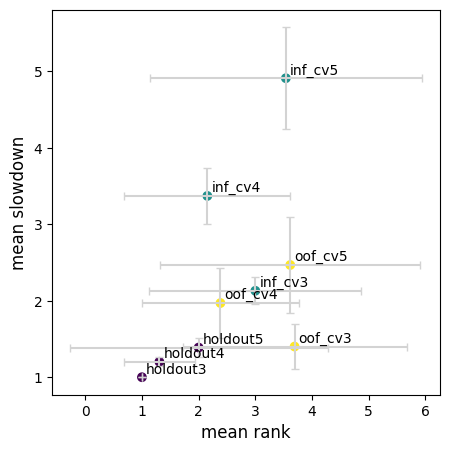

In [11]:
figs, ax = plt.subplots(figsize=(5, 5))
ax.set_xlabel("mean rank", fontsize=12)
ax.set_ylabel("mean slowdown", fontsize=12)
ax.errorbar(
    scatter_df["mean rank"],
    scatter_df["mean slowdown"],
    xerr=scatter_df["std rank"],
    yerr=scatter_df["std slowdown"],
    linestyle="None",
    ecolor="lightgray",
    capsize=3,
)
ax.scatter(
    scatter_df["mean rank"],
    scatter_df["mean slowdown"],
    c=scatter_df["color"],
)
for i, row in scatter_df.iterrows():
    ax.annotate(
        row["point_label"],
        (row["mean rank"], row["mean slowdown"]),
        xytext=(4, 4),
        textcoords="offset pixels",
        rotation=0,
    )
plt.show()

### Exploring regularization hyperparameters with cross-validation

In [12]:
def evaluate_and_plot(data, trainables, plot_label):
    df = evaluate(data, [3], trainables)
    fig, ax = plt.subplots()
    ax.set_ylim([0.0, 1.1])
    ho_df = df[df["regime"] == "holdout"]
    inf_df = df[df["regime"] == "inf_cv"]
    oof_df = df[df["regime"] == "oof_cv"]
    ax.semilogx(ho_df["config_name"], ho_df["score_avg"], label="holdout")
    ax.errorbar(inf_df["config_name"], inf_df["score_avg"], yerr=inf_df["score_std"], capsize=4, label="inf_cv")
    ax.errorbar(oof_df["config_name"], oof_df["score_avg"], yerr=oof_df["score_std"], capsize=4, label="oof_cv")
    ax.legend()
    ax.set_title(plot_label[:plot_label.rfind("  ")])
    ax.set_xlabel(plot_label[plot_label.rfind("  ") + 2:])
    ax.set_ylabel("balanced accuracy")
    plt.show()
    # IPython.display.display(df)

### Prepare spectf Dataset

In [13]:
data = load_data("spectf", TEST_SIZE, False)
print(f"name '{data['name']}', top_feature '{data['top_feature']}'")
print(f"training labels: {data['train_y'].value_counts().to_dict()}")
print(f"holdout labels: {data['holdout_y'].value_counts().to_dict()}")
pd.concat([data["train_y"], data["train_X"]], axis=1)

name 'spectf', top_feature 'f20s'
training labels: {'1': 169, '0': 63}
holdout labels: {'1': 85, '0': 32}


,overall_diagnosis,f1r,f1s,f2r,f2s,f3r,f3s,f4r,f4s,f5r,...,f18r,f18s,f19r,f19s,f20r,f20s,f21r,f21s,f22r,f22s
247,1,64,72,70,74,63,70,73,74,61,...,64,68,64,68,69,71,65,65,56,58
160,1,58,65,78,76,64,58,74,70,63,...,71,62,77,62,72,62,49,35,30,20
261,0,56,56,63,66,76,76,68,73,62,...,71,73,60,53,61,73,67,68,59,56
81,1,67,68,73,78,65,63,67,60,63,...,61,56,76,75,74,77,76,74,59,68
325,0,71,75,78,78,68,67,75,72,67,...,63,66,51,57,77,67,78,76,60,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0,65,68,70,78,65,72,72,74,64,...,67,63,64,67,67,77,66,66,59,57
252,1,40,73,61,74,61,67,56,75,64,...,64,69,67,68,59,66,55,62,51,60
88,1,68,63,62,58,60,57,69,78,59,...,66,67,74,70,77,74,66,60,59,56
310,0,62,67,68,70,65,70,73,77,69,...,71,73,72,71,73,77,72,76,64,66


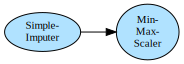

In [14]:
config.get_prefix_rasl(data["name"], False).visualize()

### Experiments with spectf Dataset

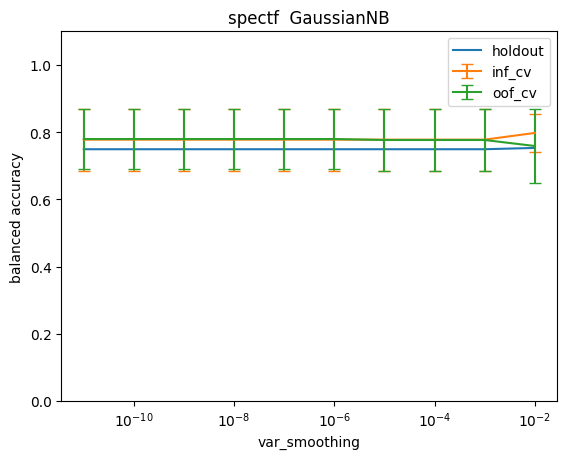

CPU times: user 20.1 s, sys: 591 ms, total: 20.7 s
Wall time: 19.8 s


In [15]:
%%time
evaluate_and_plot(
    data,
    [(x, create_pipeline(data["name"], NonIncWrapper(op=GaussianNB(var_smoothing=x))))
    for x in logrange(1e-11, 1e-2, 10)],
    f"{data['name']}  GaussianNB  var_smoothing"
)

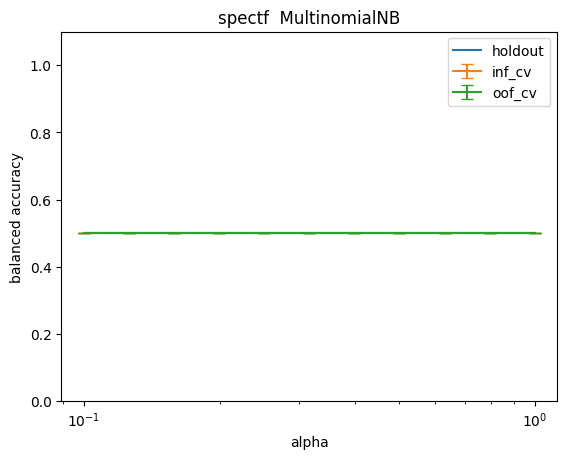

CPU times: user 31.9 s, sys: 197 ms, total: 32.1 s
Wall time: 31.7 s


In [16]:
%%time
evaluate_and_plot(
    data,
    [(x, create_pipeline(data["name"], NonIncWrapper(op=MultinomialNB(alpha=x))))
    for x in logrange(0.1, 1, 11)],
    f"{data['name']}  MultinomialNB  alpha"
)

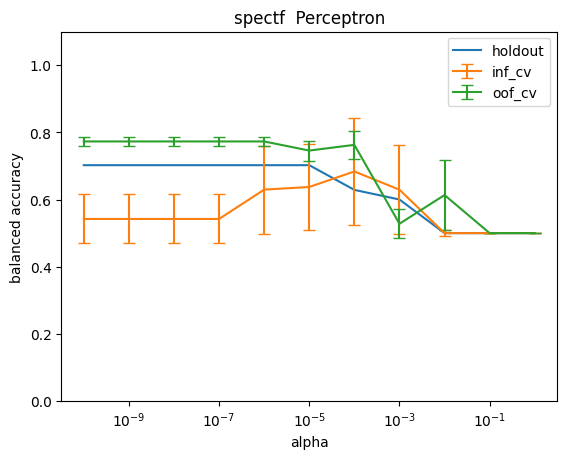

CPU times: user 21.5 s, sys: 201 ms, total: 21.7 s
Wall time: 21.4 s


In [17]:
%%time
evaluate_and_plot(
    data,
    [(x, create_pipeline(data["name"], NonIncWrapper(
        op=Perceptron(penalty="l2", alpha=x, random_state=42))))
    for x in logrange(1e-10, 1, 11)],
    f"{data['name']}  Perceptron  alpha"
)

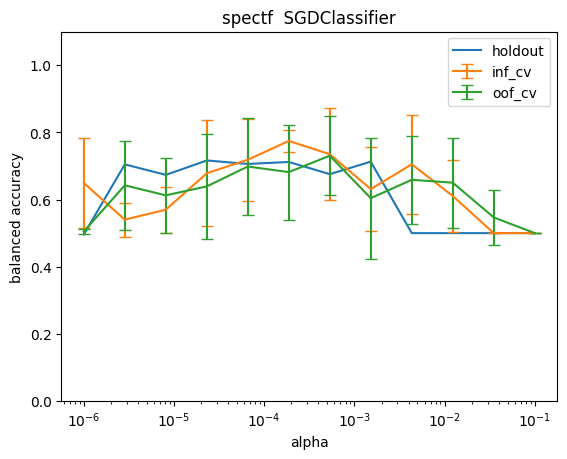

CPU times: user 23.1 s, sys: 126 ms, total: 23.2 s
Wall time: 22.9 s


In [18]:
%%time
evaluate_and_plot(
    data,
    [(x, create_pipeline(data["name"], NonIncWrapper(
        op=SGDClassifier(alpha=x, random_state=42))))
    for x in logrange(1e-6, 1e-1, 12)],
    f"{data['name']}  SGDClassifier  alpha"
)

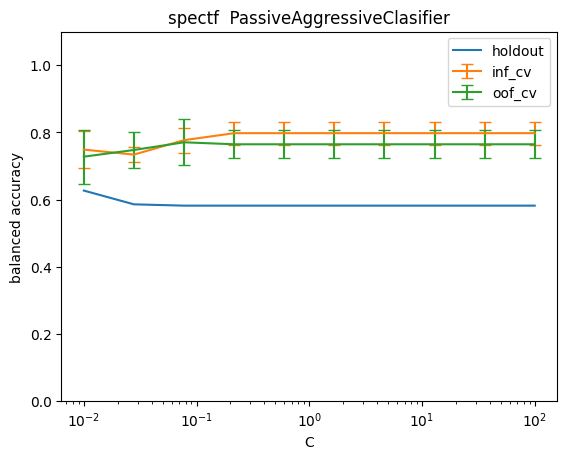

CPU times: user 21.6 s, sys: 123 ms, total: 21.8 s
Wall time: 21.5 s


In [19]:
%%time
evaluate_and_plot(
    data,
    [(x, create_pipeline(data["name"], NonIncWrapper(
        op=PassiveAggressiveClassifier(C=x, random_state=42))))
    for x in logrange(1e-2, 1e2, 10)],
    f"{data['name']}  PassiveAggressiveClasifier  C"
)

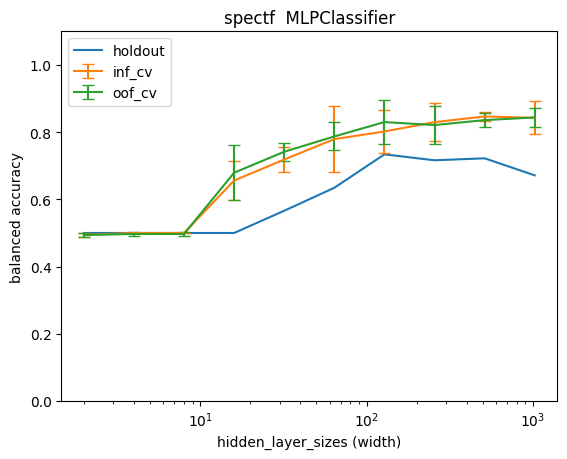

CPU times: user 18min 46s, sys: 49min 40s, total: 1h 8min 26s
Wall time: 8min 53s


In [20]:
%%time
evaluate_and_plot(
    data,
    [(int(x), create_pipeline(data["name"], NonIncWrapper(
        op=MLPClassifier(hidden_layer_sizes=(int(x),) * 2, random_state=42))))
    for x in logrange(2, 1024, 10)],
    f"{data['name']}  MLPClassifier  hidden_layer_sizes (width)"
)

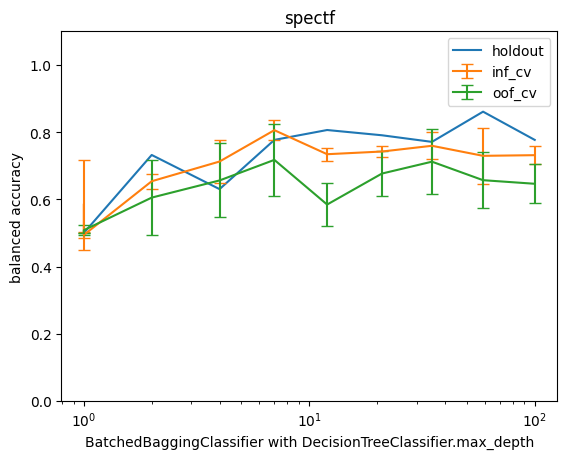

CPU times: user 18.9 s, sys: 176 ms, total: 19 s
Wall time: 18.8 s


In [21]:
%%time
from lale.lib.sklearn import DecisionTreeClassifier
evaluate_and_plot(
    data,
    [(int(x), create_pipeline(data["name"], NonIncWrapper(
        op=BatchedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=int(x)))
     ))) for x in logrange(1, 100, 10)],
    f"{data['name']}  BatchedBaggingClassifier with DecisionTreeClassifier.max_depth"
)

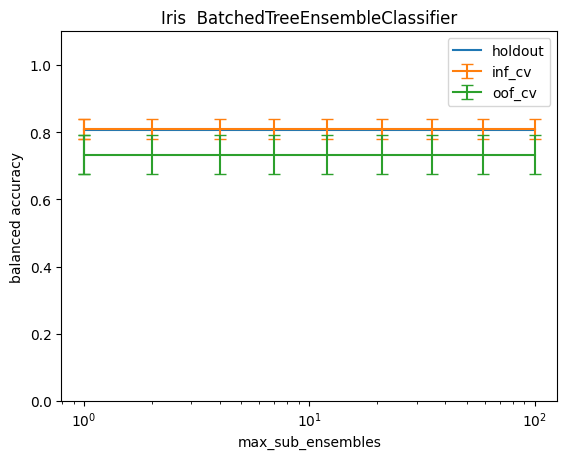

CPU times: user 21.1 s, sys: 172 ms, total: 21.3 s
Wall time: 21 s


In [22]:
%%time
evaluate_and_plot(
    data,
    [(int(x), create_pipeline(data["name"], NonIncWrapper(
        op=BatchedTreeEnsembleClassifier(max_sub_ensembles=int(x)))))
    for x in logrange(1, 100, 10)],
    "Iris  BatchedTreeEnsembleClassifier  max_sub_ensembles"
)

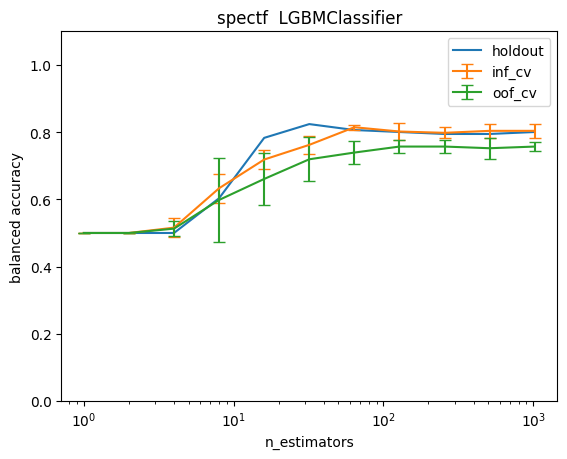

CPU times: user 23.2 s, sys: 135 ms, total: 23.3 s
Wall time: 23.1 s


In [23]:
%%time
evaluate_and_plot(
    data,
    [(int(x), create_pipeline(data["name"], NonIncWrapper(
        op=LGBMClassifier(n_estimators=int(x)))))
    for x in logrange(1, 1024, 11)],
    f"{data['name']}  LGBMClassifier  n_estimators"
)

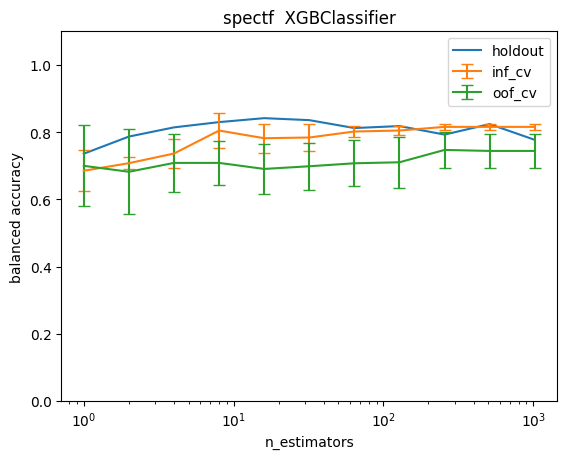

CPU times: user 57.9 s, sys: 115 ms, total: 58 s
Wall time: 57.8 s


In [24]:
%%time
evaluate_and_plot(
    data,
    [(int(x), create_pipeline(data["name"], NonIncWrapper(
        op=XGBClassifier(n_estimators=int(x)))))
    for x in logrange(1, 1024, 11)],
    f"{data['name']}  XGBClassifier  n_estimators"
)

### Prepare breast-cancer Dataset

In [25]:
data = load_data("breast-cancer", TEST_SIZE, False)
print(f"name '{data['name']}', top_feature '{data['top_feature']}'")
print(f"training labels: {data['train_y'].value_counts().to_dict()}")
print(f"holdout labels: {data['holdout_y'].value_counts().to_dict()}")
pd.concat([data["train_y"], data["train_X"]], axis=1)

name 'breast-cancer', top_feature 'tumor-size'
training labels: {'no-recurrence-events': 133, 'recurrence-events': 57}
holdout labels: {'no-recurrence-events': 68, 'recurrence-events': 28}


,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
183,recurrence-events,50-59,ge40,30-34,3-5,no,3,left,left_low,no
276,no-recurrence-events,40-49,premeno,25-29,0-2,no,2,left,left_up,yes
39,no-recurrence-events,40-49,premeno,10-14,0-2,no,1,right,right_low,no
148,no-recurrence-events,40-49,premeno,40-44,0-2,no,2,right,left_low,no
127,no-recurrence-events,60-69,ge40,25-29,0-2,no,2,left,left_low,no
...,...,...,...,...,...,...,...,...,...,...
89,no-recurrence-events,50-59,ge40,30-34,0-2,no,1,left,left_up,no
71,no-recurrence-events,60-69,ge40,25-29,3-5,None,1,right,left_up,yes
252,no-recurrence-events,40-49,premeno,30-34,0-2,no,1,left,right_up,no
88,no-recurrence-events,50-59,ge40,20-24,0-2,no,1,right,left_low,no


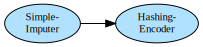

In [26]:
config.get_prefix_rasl(data["name"], False).visualize()

### Experiments with breast-cancer Dataset

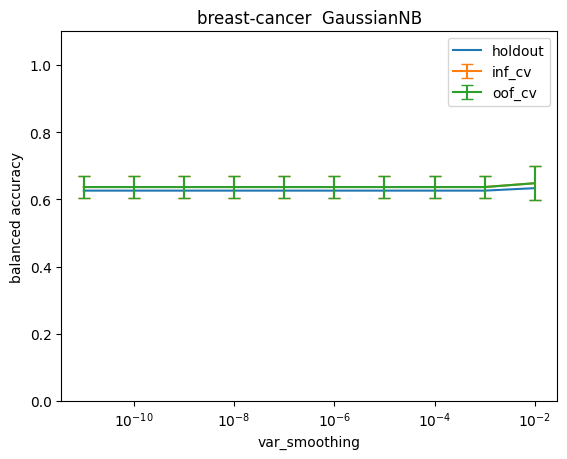

CPU times: user 11.7 s, sys: 648 ms, total: 12.4 s
Wall time: 11.5 s


In [27]:
%%time
evaluate_and_plot(
    data,
    [(x, create_pipeline(data["name"], NonIncWrapper(
        op=GaussianNB(var_smoothing=x))))
    for x in logrange(1e-11, 1e-2, 10)],
    f"{data['name']}  GaussianNB  var_smoothing"
)

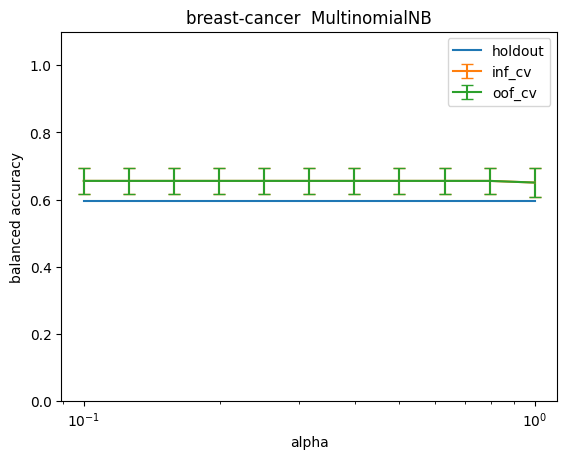

CPU times: user 13.1 s, sys: 167 ms, total: 13.3 s
Wall time: 13 s


In [28]:
%%time
evaluate_and_plot(
    data,
    [(x, create_pipeline(data["name"], NonIncWrapper(
        op=MultinomialNB(alpha=x))))
    for x in logrange(0.1, 1, 11)],
    f"{data['name']}  MultinomialNB  alpha"
)

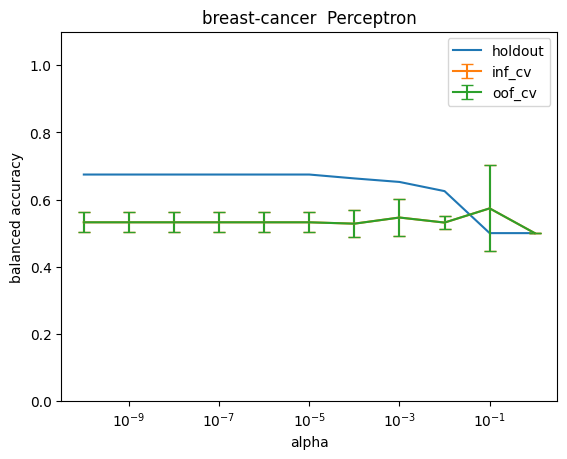

CPU times: user 13.1 s, sys: 169 ms, total: 13.3 s
Wall time: 13 s


In [29]:
%%time
evaluate_and_plot(
    data,
    [(x, create_pipeline(data["name"], NonIncWrapper(
        op=Perceptron(penalty="l2", alpha=x, random_state=42))))
    for x in logrange(1e-10, 1, 11)],
    f"{data['name']}  Perceptron  alpha"
)

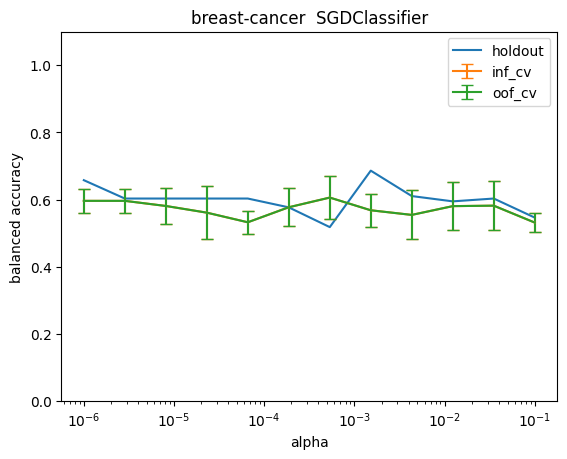

CPU times: user 14.3 s, sys: 129 ms, total: 14.4 s
Wall time: 14.2 s


In [30]:
%%time
evaluate_and_plot(
    data,
    [(x, create_pipeline(data["name"], NonIncWrapper(
        op=SGDClassifier(alpha=x, random_state=42))))
    for x in logrange(1e-6, 1e-1, 12)],
    f"{data['name']}  SGDClassifier  alpha"
)

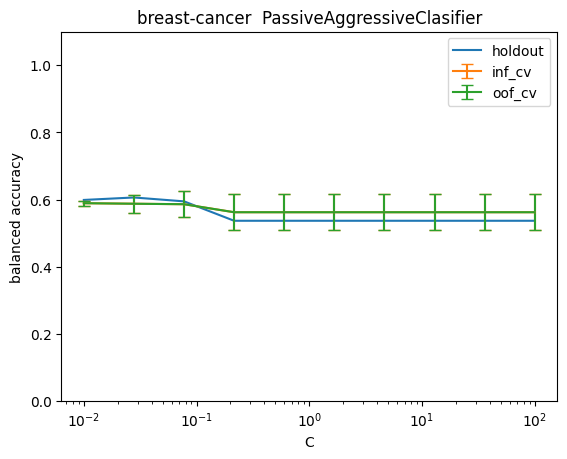

CPU times: user 12.5 s, sys: 160 ms, total: 12.6 s
Wall time: 12.4 s


In [31]:
%%time
evaluate_and_plot(
    data,
    [(x, create_pipeline(data["name"], NonIncWrapper(
        op=PassiveAggressiveClassifier(C=x, random_state=42))))
    for x in logrange(1e-2, 1e2, 10)],
    f"{data['name']}  PassiveAggressiveClasifier  C"
)

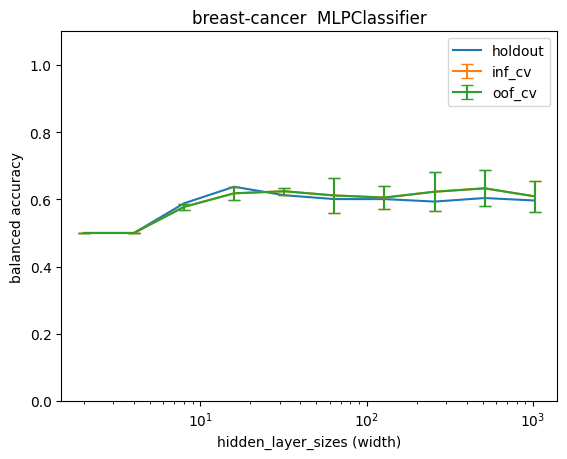

CPU times: user 15min 32s, sys: 40min 10s, total: 55min 43s
Wall time: 7min 11s


In [32]:
%%time
evaluate_and_plot(
    data,
    [(int(x), create_pipeline(data["name"], NonIncWrapper(
        op=MLPClassifier(hidden_layer_sizes=(int(x),) * 2, random_state=42))))
    for x in logrange(2, 1024, 10)],
    f"{data['name']}  MLPClassifier  hidden_layer_sizes (width)"
)

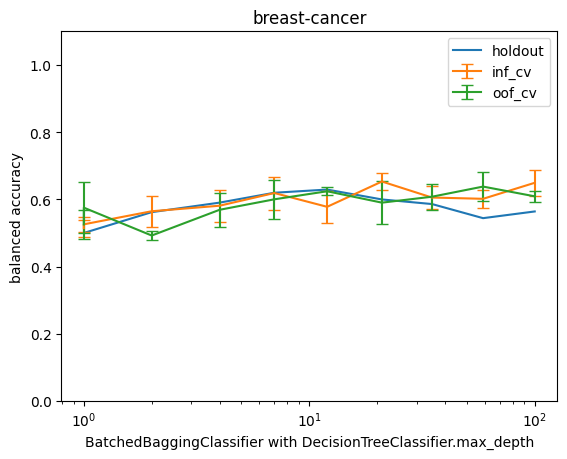

CPU times: user 11.1 s, sys: 196 ms, total: 11.3 s
Wall time: 11.1 s


In [33]:
%%time
from lale.lib.sklearn import DecisionTreeClassifier
evaluate_and_plot(
    data,
    [(int(x), create_pipeline(data["name"], NonIncWrapper(
        op=BatchedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=int(x)))
     ))) for x in logrange(1, 100, 10)],
    f"{data['name']}  BatchedBaggingClassifier with DecisionTreeClassifier.max_depth"
)

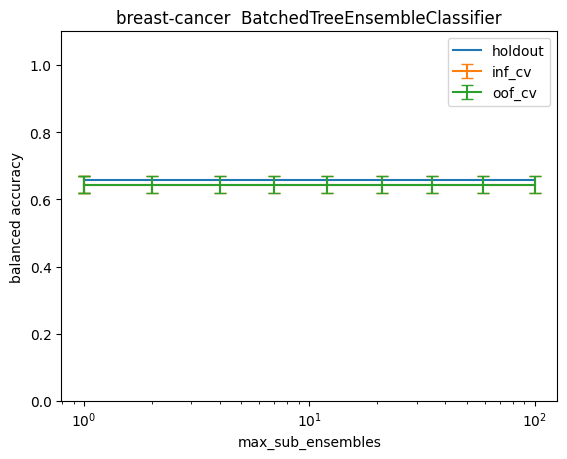

CPU times: user 12.5 s, sys: 222 ms, total: 12.7 s
Wall time: 12.5 s


In [34]:
%%time
evaluate_and_plot(
    data,
    [(int(x), create_pipeline(data["name"], NonIncWrapper(
        op=BatchedTreeEnsembleClassifier(max_sub_ensembles=int(x)))))
    for x in logrange(1, 100, 10)],
    f"{data['name']}  BatchedTreeEnsembleClassifier  max_sub_ensembles"
)

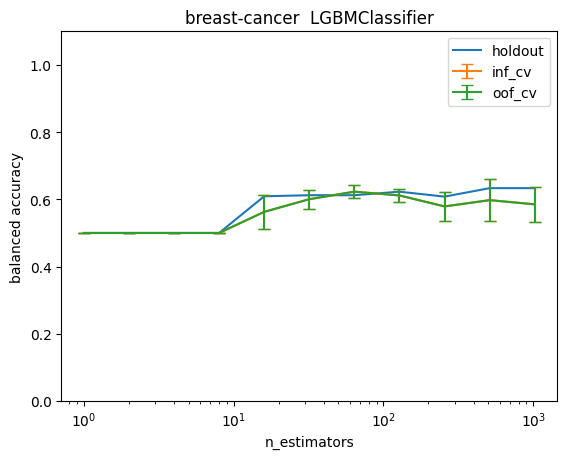

CPU times: user 14.1 s, sys: 191 ms, total: 14.3 s
Wall time: 14.1 s


In [35]:
%%time
evaluate_and_plot(
    data,
    [(int(x), create_pipeline(data["name"], NonIncWrapper(
        op=LGBMClassifier(n_estimators=int(x)))))
    for x in logrange(1, 1024, 11)],
    f"{data['name']}  LGBMClassifier  n_estimators"
)

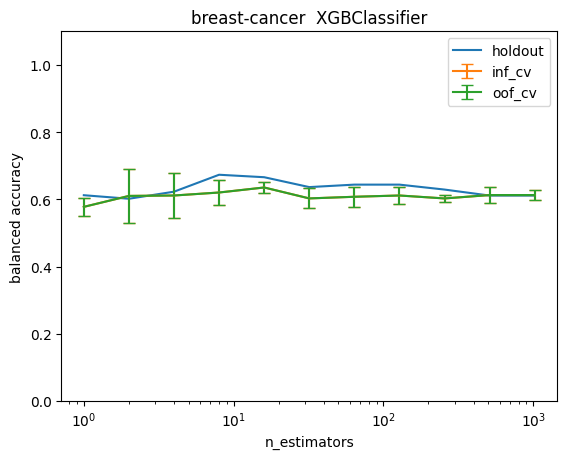

CPU times: user 47 s, sys: 130 ms, total: 47.1 s
Wall time: 46.9 s


In [36]:
%%time
evaluate_and_plot(
    data,
    [(int(x), create_pipeline(data["name"], NonIncWrapper(
        op=XGBClassifier(n_estimators=int(x)))))
    for x in logrange(1, 1024, 11)],
    f"{data['name']}  XGBClassifier  n_estimators"
)

### Prepare credit-g Dataset

In [37]:
data = load_data("credit-g", TEST_SIZE, False)
print(f"name '{data['name']}', top_feature '{data['top_feature']}'")
print(f"training labels: {data['train_y'].value_counts().to_dict()}")
print(f"holdout labels: {data['holdout_y'].value_counts().to_dict()}")
pd.concat([data["train_y"], data["train_X"]], axis=1)

name 'credit-g', top_feature 'credit_amount'
training labels: {'good': 462, 'bad': 205}
holdout labels: {'good': 238, 'bad': 95}


,class,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,...,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
900,bad,<0,16.0,critical/other existing credit,new car,2625.0,<100,>=7,2.0,male single,...,4.0,life insurance,43.0,bank,rent,1.0,skilled,1.0,yes,yes
988,good,<0,24.0,existing paid,used car,6579.0,<100,unemployed,4.0,male single,...,2.0,no known property,29.0,none,for free,1.0,high qualif/self emp/mgmt,1.0,yes,yes
766,bad,<0,30.0,existing paid,furniture/equipment,3108.0,<100,<1,2.0,male div/sep,...,4.0,life insurance,31.0,none,own,1.0,unskilled resident,1.0,none,yes
529,good,<0,6.0,existing paid,new car,662.0,<100,<1,3.0,male single,...,4.0,real estate,41.0,none,own,1.0,unskilled resident,2.0,yes,yes
411,good,no checking,33.0,critical/other existing credit,used car,7253.0,<100,4<=X<7,3.0,male single,...,2.0,car,35.0,none,own,2.0,high qualif/self emp/mgmt,1.0,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,good,no checking,14.0,delayed previously,new car,802.0,<100,1<=X<4,4.0,male single,...,2.0,car,27.0,none,own,2.0,unskilled resident,1.0,none,yes
88,good,<0,18.0,existing paid,new car,2249.0,100<=X<500,4<=X<7,4.0,male single,...,3.0,car,30.0,none,own,1.0,high qualif/self emp/mgmt,2.0,yes,yes
958,bad,<0,28.0,existing paid,new car,4006.0,<100,1<=X<4,3.0,male single,...,2.0,car,45.0,none,own,1.0,unskilled resident,1.0,none,yes
892,good,<0,12.0,critical/other existing credit,new car,2171.0,<100,1<=X<4,4.0,male single,...,4.0,life insurance,38.0,bank,own,2.0,unskilled resident,1.0,none,no


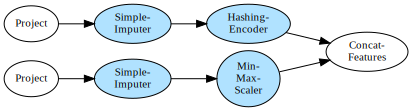

In [38]:
config.get_prefix_rasl(data["name"], False).visualize()

### Experiments with credit-g Dataset

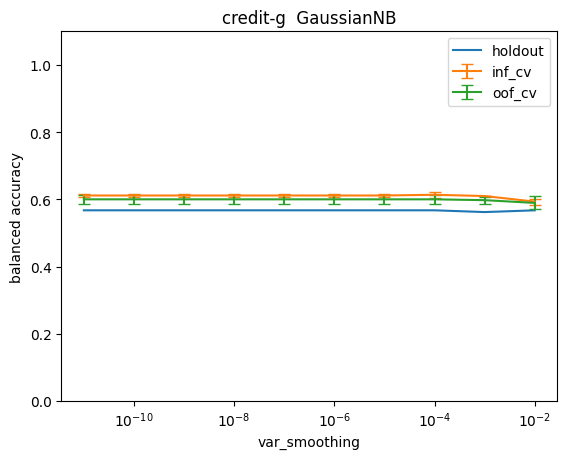

CPU times: user 26.9 s, sys: 688 ms, total: 27.6 s
Wall time: 26.7 s


In [39]:
%%time
evaluate_and_plot(
    data,
    [(x,  create_pipeline(data["name"], NonIncWrapper(
        op=GaussianNB(var_smoothing=x))))
    for x in logrange(1e-11, 1e-2, 10)],
    f"{data['name']}  GaussianNB  var_smoothing"
)

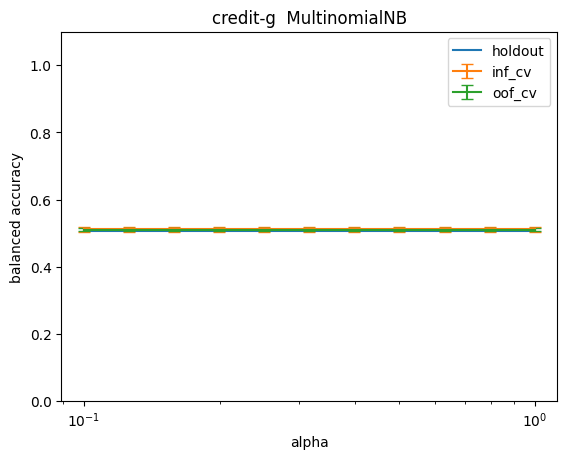

CPU times: user 34.3 s, sys: 110 ms, total: 34.4 s
Wall time: 34.1 s


In [40]:
%%time
evaluate_and_plot(
    data,
    [(x, create_pipeline(data["name"], NonIncWrapper(op=MultinomialNB(alpha=x))))
    for x in logrange(0.1, 1, 11)],
    f"{data['name']}  MultinomialNB  alpha"
)

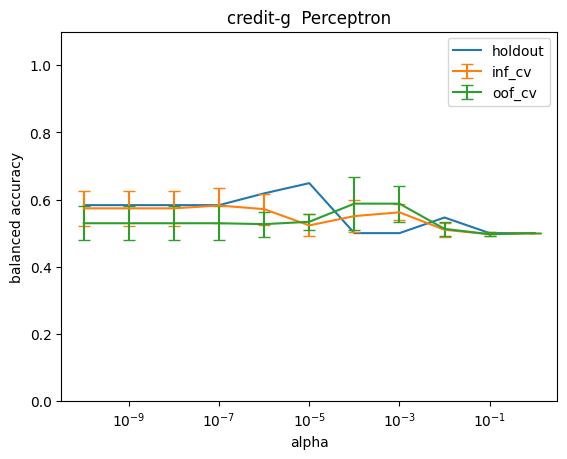

CPU times: user 27.1 s, sys: 172 ms, total: 27.3 s
Wall time: 27 s


In [41]:
%%time
evaluate_and_plot(
    data,
    [(x, create_pipeline(data["name"], NonIncWrapper(
        op=Perceptron(penalty="l2", alpha=x, random_state=42))))
    for x in logrange(1e-10, 1, 11)],
    f"{data['name']}  Perceptron  alpha"
)

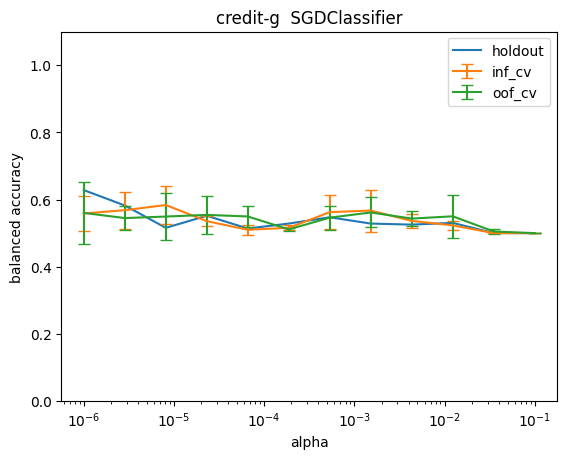

CPU times: user 30.5 s, sys: 104 ms, total: 30.6 s
Wall time: 30.4 s


In [42]:
%%time
evaluate_and_plot(
    data,
    [(x, create_pipeline(data["name"], NonIncWrapper(
        op=SGDClassifier(alpha=x, random_state=42))))
    for x in logrange(1e-6, 1e-1, 12)],
    f"{data['name']}  SGDClassifier  alpha"
)

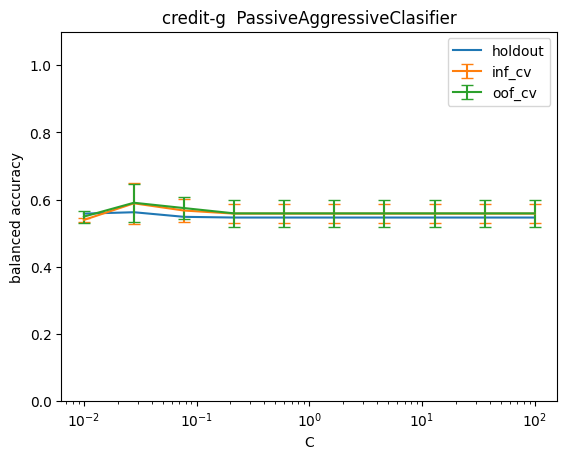

CPU times: user 27.4 s, sys: 246 ms, total: 27.7 s
Wall time: 27.4 s


In [43]:
%%time
evaluate_and_plot(
    data,
    [(x, create_pipeline(data["name"], NonIncWrapper(
        op=PassiveAggressiveClassifier(C=x, random_state=42))))
    for x in logrange(1e-2, 1e2, 10)],
    f"{data['name']}  PassiveAggressiveClasifier  C"
)

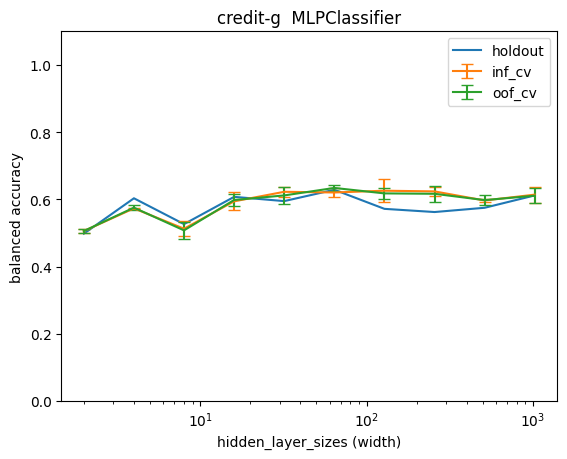

CPU times: user 57min 10s, sys: 2h 25min 39s, total: 3h 22min 49s
Wall time: 25min 57s


In [44]:
%%time
evaluate_and_plot(
    data,
    [(int(x), create_pipeline(data["name"], NonIncWrapper(
        op=MLPClassifier(hidden_layer_sizes=(int(x),) * 2, random_state=42))))
    for x in logrange(2, 1024, 10)],
    f"{data['name']}  MLPClassifier  hidden_layer_sizes (width)"
)

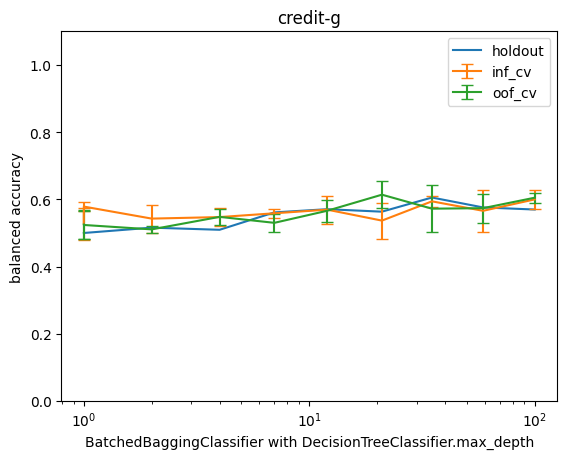

CPU times: user 31.1 s, sys: 120 ms, total: 31.2 s
Wall time: 30.9 s


In [45]:
%%time
from lale.lib.sklearn import DecisionTreeClassifier
evaluate_and_plot(
    data,
    [(int(x), create_pipeline(data["name"], NonIncWrapper(
        op=BatchedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=int(x))))
     )) for x in logrange(1, 100, 10)],
    f"{data['name']}  BatchedBaggingClassifier with DecisionTreeClassifier.max_depth"
)

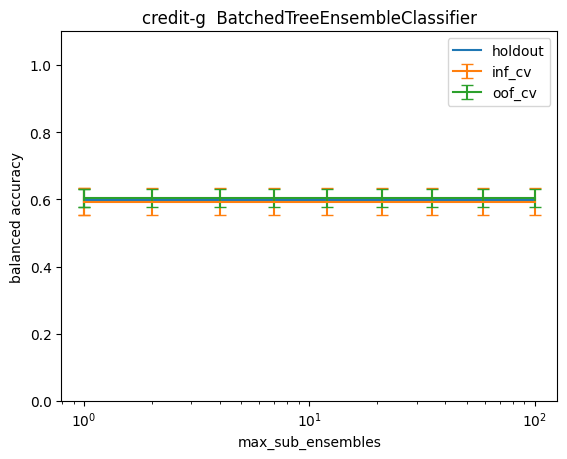

CPU times: user 30.3 s, sys: 235 ms, total: 30.5 s
Wall time: 30.2 s


In [46]:
%%time
evaluate_and_plot(
    data,
    [(int(x), create_pipeline(data["name"], NonIncWrapper(
        op=BatchedTreeEnsembleClassifier(max_sub_ensembles=int(x)))))
    for x in logrange(1, 100, 10)],
    f"{data['name']}  BatchedTreeEnsembleClassifier  max_sub_ensembles"
)

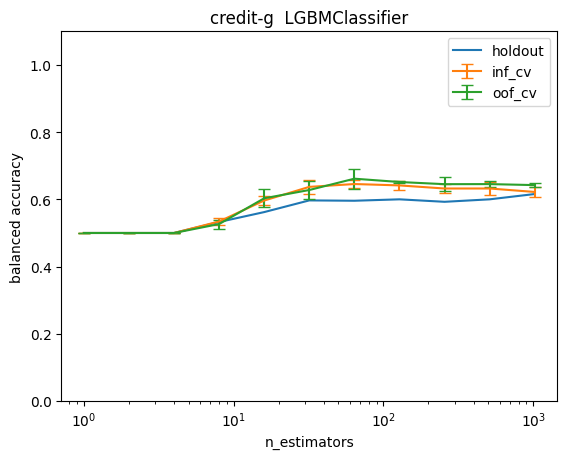

CPU times: user 33.1 s, sys: 279 ms, total: 33.4 s
Wall time: 33.1 s


In [47]:
%%time
evaluate_and_plot(
    data,
    [(int(x), create_pipeline(data["name"], NonIncWrapper(
        op=LGBMClassifier(n_estimators=int(x)))))
    for x in logrange(1, 1024, 11)],
    f"{data['name']}  LGBMClassifier  n_estimators"
)

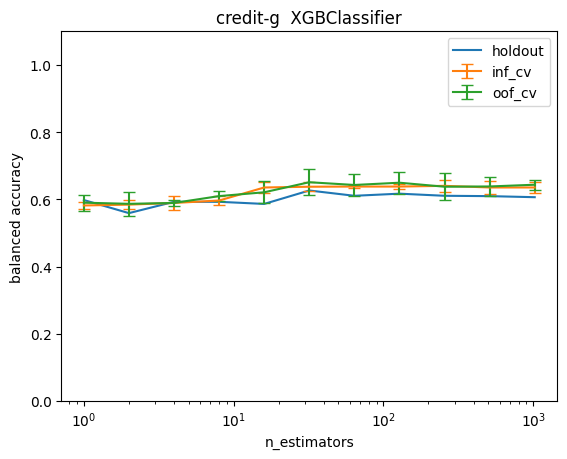

CPU times: user 1min 4s, sys: 122 ms, total: 1min 4s
Wall time: 1min 4s


In [48]:
%%time
evaluate_and_plot(
    data,
    [(int(x), create_pipeline(data["name"], NonIncWrapper(
        op=XGBClassifier(n_estimators=int(x)))))
    for x in logrange(1, 1024, 11)],
    f"{data['name']}  XGBClassifier  n_estimators"
)